# 3D Volume to Volume GAN

In [1]:
%matplotlib inline

import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
import time

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../scripts')

import pix3pix as p3p
import helper as hp
import data_loader3D as dl
import deconvolution as deconv

sys.path.insert(0, '../scripts/NanoImagingPack')
from microscopy import PSF3D

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

## initialize and test the data_loader

In [4]:
path = glob('../data/3D/NESb/*')
path = [item for item in path if not item.endswith('.txt')]

dl.get_volume_dimension(path)

volume dimension of volumes:
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)


In [5]:
vol_dim = (1024, 1024, 9)

dataloader = dl.DataLoader(dataset_name='NESb', vol_size=vol_dim)
dataloader.vol_size

(1024, 1024, 9)

## test the 3D psf for a volume

In [13]:
path = '../data/3D/NESb/NESb_C2_TP1.tiff'
vol = io.imread(path)
vol = hp.swapAxes(vol, swap=True)

# compute OTF
start_otf = time.time()
otf = PSF3D(im=vol.shape, ret_val = 'OTF')
end_otf = time.time()

# perform convolution on stack with computed otf (with numpy)
start_conv_np = time.time()
vol_otf = deconv.conv3d_fft(vol, otf)
end_conv_np = time.time()

# perform convolution on stack with computed otf (with tensorflow)
# start_conv_tf = time.time()
# vol_otf_tf = deconv.conv3d_fft_tf(vol, otf)
# end_conv_tf = time.time()

# select a specified number of random stacks
i = np.random.randint(low=0, high=vol.shape[2], size=1)[0]
print('stack number:\t', i+1,'/',vol.shape[2])
img = vol[:,:,i]
img_otf = vol_otf[:,:,i]
img_otf_tf = vol_otf_tf[:,:,i]

print('Time for compute OTF:\t\t', end_otf - start_otf, 's')
print('Time for convolve with numpy:\t', end_conv_np - start_conv_np, 's')
# print('Time for convolve with tensorflow:\t', end_conv_tf - start_conv_tf, 's')

image shape (before):	 (9, 1024, 1024)
image shape (after):	 (1024, 1024, 9)
stack number:	 9 / 9
Time for compute OTF:		 3.491011142730713 s
Time for convolve with numpy:	 2.4521799087524414 s


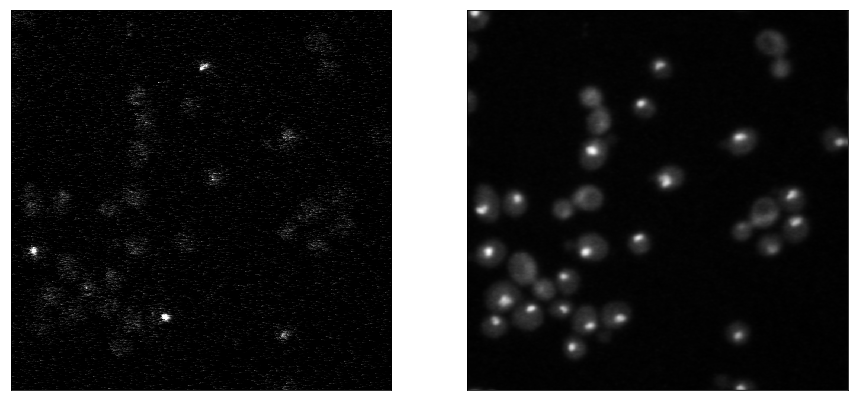

In [14]:
f = plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img, cmap='gray'); plt.xticks([]); plt.yticks([])
plt.subplot(122); plt.imshow(img_otf, cmap='gray'); plt.xticks([]); plt.yticks([])
# plt.subplot(133); plt.imshow(img_otf_tf, cmap='gray'); plt.xticks([]); plt.yticks([])
plt.show()

## initialize the volume to volume GAN

In [46]:
gan = p3p.Pix3Pix(vol_size=vol_dim[0], vol_depth=vol_dim[2], 
                  d_name='NESb', enhancement=p3p.Enhancement.SPATIAL_UP)

# enhancement=p3p.Enhancement.FREQUENCY_UP)

model input:			 (?, 1024, 1024, 9, 1)
downsampling:			 (?, 512, 512, 8, 64)
downsampling:			 (?, 256, 256, 4, 128)
downsampling:			 (?, 128, 128, 2, 256)
downsampling:			 (?, 64, 64, 1, 512)
downsampling:			 (?, 32, 32, 1, 512)
downsampling:			 (?, 16, 16, 1, 512)
downsampling:			 (?, 8, 8, 1, 512)
manipulation of stack axes: [9, 8, 4, 2, 1, 1, 1, 1] 7
upsampling:   7 		 (?, 16, 16, 1, 512)
upsampling:   6 		 (?, 32, 32, 1, 512)
upsampling:   5 		 (?, 64, 64, 1, 512)
upsampling:   4 		 (?, 128, 128, 2, 256)
upsampling:   3 		 (?, 256, 256, 4, 128)
upsampling:   2 		 (?, 512, 512, 8, 64)
model output: 1 		 (?, 1024, 1024, 9, 1)
finish Pix3Pix __init__


## train volume to volume GAN

In [ ]:
epochs = 1

gan.train(epochs=epochs)